# D4. ENSEMBLE METHODS : ADABOOST REGRESSOR WITHOUT OUTLIERS

__4.1 Importing Libraries and Datasets__

__4.2 AdaBoost Regressor__

__4.3 Model Evaluation : Training Metrics__

__4.4 Model Evaluation : Cross Validation__

__4.5 Model Evaluation : Test Dataset__

__4.6 Feature Importances__

__4.7 Residuals' Distribution__

__4.8 Scatterplots with fitted line (Train Dataset)__

__4.9 Saving Results__

## 4.1 Importing Libraries and Datasets

In [1]:
# Libraries

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import StandardScaler

import shap
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', 100)

In [2]:
# Train Dataset

train_data = pd.read_csv("BG_Train_Dataset_No_Outliers.csv") 
train_df = train_data.copy()
train_df.head(1)

,Age,BMI,Smoking,Pre Operative Fast,Pre Operative Glucose,Sex,Cort,LV,ASA,Post Operative Glucose
0,3.321,4.427,1.574,5.794,8.838,1,1,1,2,129


In [3]:
# Test Dataset

test_data = pd.read_csv("BG_Test_Dataset_No_Outliers.csv") 
test_df = test_data.copy()
test_df.head(1)

,Age,BMI,Smoking,Pre Operative Fast,Pre Operative Glucose,Sex,Cort,LV,ASA,Post Operative Glucose
0,3.728,5.596,0.0,7.543,8.058,0,0,2,2,115


## 4.2 AdaBoost Regressor

In [4]:
# Defining X_train and Y_train

Y_train = train_df['Post Operative Glucose']
X_train = train_df.drop('Post Operative Glucose', axis = 1)
X_train.head(1)

,Age,BMI,Smoking,Pre Operative Fast,Pre Operative Glucose,Sex,Cort,LV,ASA
0,3.321,4.427,1.574,5.794,8.838,1,1,1,2


In [5]:
# Using the KFold function for cross-validation

cv = KFold(n_splits = 5, shuffle = True, random_state = 126)

In [6]:
# Defining Grid for Hyperparameter Tuning - LR

grid_LR = {'base_estimator': [LinearRegression()], 
        'n_estimators': [10,20,40,60,80,100],
        'learning_rate': [0.001,0.01,0.1,0.4,0.7,1],
        'loss' : ['linear', 'square', 'exponential']}

In [7]:
# Defining Grid for Hyperparameter Tuning - DTR

grid_DTR = {'base_estimator': [DecisionTreeRegressor()], 
        'n_estimators': [10,20,40,60,80,100],
        'learning_rate': [0.001,0.01,0.1,0.4,0.7,1],
        'loss' : ['linear', 'square', 'exponential'],
        # DTR hyperparameters
        'base_estimator__max_depth': [4,8,None],
        'base_estimator__min_samples_split': [4,6,8],
        'base_estimator__min_samples_leaf': [4,6,8],
        'base_estimator__max_leaf_nodes' : [6,8,10]}

In [8]:
# Instantiating GridSearchCV 

AdaBoost_search_LR = GridSearchCV(AdaBoostRegressor(random_state = 126), 
                            grid_LR, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1 ,verbose = 1)

AdaBoost_search_DTR = GridSearchCV(AdaBoostRegressor(random_state = 126), 
                            grid_DTR, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1 ,verbose = 1)

In [9]:
# Searching for the best parameters for AdaBoost - LR

CV_AdaBoost_results_LR = AdaBoost_search_LR.fit(X_train, Y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [10]:
# Searching for the best parameters for AdaBoost - DTR

CV_AdaBoost_results_DTR = AdaBoost_search_DTR.fit(X_train, Y_train)

Fitting 5 folds for each of 8748 candidates, totalling 43740 fits


In [11]:
# Displaying the best parameters - LR

AdaBoost_Best_Parameters_LR = pd.DataFrame(CV_AdaBoost_results_LR.best_params_,
                                        index = ['Best AdaBoost Regressor Parameters-LR'])

AdaBoost_Best_Parameters_LR = AdaBoost_Best_Parameters_LR.transpose()
AdaBoost_Best_Parameters_LR

,Best AdaBoost Regressor Parameters-LR
base_estimator,LinearRegression()
learning_rate,0.4
loss,linear
n_estimators,10


In [12]:
# Displaying the best parameters - DTR

AdaBoost_Best_Parameters_DTR = pd.DataFrame(CV_AdaBoost_results_DTR.best_params_,
                                        index = ['Best AdaBoost Regressor Parameters-DTR'])

AdaBoost_Best_Parameters_DTR = AdaBoost_Best_Parameters_DTR.transpose()
AdaBoost_Best_Parameters_DTR

,Best AdaBoost Regressor Parameters-DTR
base_estimator,DecisionTreeRegressor()
base_estimator__max_depth,8
base_estimator__max_leaf_nodes,6
base_estimator__min_samples_leaf,4
base_estimator__min_samples_split,4
learning_rate,1
loss,square
n_estimators,80


In [13]:
# Storing the values of the best parameters - DTR

best_estimator_DTR = CV_AdaBoost_results_DTR.best_params_['base_estimator']
best_n_estimators_DTR = CV_AdaBoost_results_DTR.best_params_['n_estimators']
best_learning_rate_DTR = CV_AdaBoost_results_DTR.best_params_['learning_rate']
best_loss_DTR = CV_AdaBoost_results_DTR.best_params_['loss']

# Parameter of DTR

best_base_estimator__max_depth = CV_AdaBoost_results_DTR.best_params_['base_estimator__max_depth']
best_base_estimator__max_leaf_nodes = CV_AdaBoost_results_DTR.best_params_['base_estimator__max_leaf_nodes']
best_base_estimator__min_samples_leaf = CV_AdaBoost_results_DTR.best_params_['base_estimator__min_samples_leaf']
best_base_estimator__min_samples_split = CV_AdaBoost_results_DTR.best_params_['base_estimator__min_samples_split']

In [14]:
# Instantiating the best AdaBoost Model-LR
AdaBoostModel_LR = AdaBoostRegressor(**CV_AdaBoost_results_LR.best_params_, random_state = 126).fit(X_train, Y_train)
AdaBoostModel_LR

AdaBoostRegressor(base_estimator=LinearRegression(), learning_rate=0.4,
                  n_estimators=10, random_state=126)

In [15]:
# Instantianting the best DTR

best_estimator_DTR = DecisionTreeRegressor(max_depth = best_base_estimator__max_depth,
                                        max_leaf_nodes = best_base_estimator__max_leaf_nodes,
                                        min_samples_leaf = best_base_estimator__min_samples_leaf,
                                       min_samples_split = best_base_estimator__min_samples_split)

# Instantiating the best AdaBoost Model-DTR

AdaBoostModel_DTR = AdaBoostRegressor(random_state = 126,
                                 base_estimator = best_estimator_DTR,
                                 n_estimators = best_n_estimators_DTR, 
                                  learning_rate = best_learning_rate_DTR, 
                                  loss = best_loss_DTR).fit(X_train, Y_train)
AdaBoostModel_DTR

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=8,
                                                       max_leaf_nodes=6,
                                                       min_samples_leaf=4,
                                                       min_samples_split=4),
                  learning_rate=1, loss='square', n_estimators=80,
                  random_state=126)

In [16]:
# Function that calculates the cross validated test MAE   

def cv_scores(X,Y, model,cv):
        
    cv_MAE = round(np.mean(cross_val_score(model, X, Y, cv=cv, 
                                       scoring='neg_mean_absolute_error', 
                                           error_score='raise') * (-1)),2)
    
    score = cv_MAE
    return score

In [17]:
# Calculating the cross-validated scores of each model

Score_of_LR = cv_scores(X_train,Y_train, AdaBoostModel_LR,cv)
Score_of_DTR = cv_scores(X_train,Y_train, AdaBoostModel_DTR,cv)

# The final Adaboost Model is the one with the small MAE
if Score_of_LR < Score_of_DTR:
    AdaBoostModel = AdaBoostModel_LR
else:
    AdaBoostModel = AdaBoostModel_DTR

In [18]:
# The final Bagging model
AdaBoostModel

AdaBoostRegressor(base_estimator=LinearRegression(), learning_rate=0.4,
                  n_estimators=10, random_state=126)

## 4.3 Model Evaluation : Training Metrics

In [19]:
# Getting the R^2

AB_R2 = np.round(AdaBoostModel.score(X_train, Y_train),3)

In [20]:
# Getting predictions and training metrics 

ABPredictions = AdaBoostModel.predict(X_train)
ABFeats = AdaBoostModel.n_features_in_
AB_Tr_MAE = np.round(mean_absolute_error(Y_train, ABPredictions),3)

In [21]:
# Dictionary the holds the information of  R^2, number of predictors and training metrics

dict1 = {'AdaBoost Regressor' : [AB_R2, ABFeats, AB_Tr_MAE]}

In [22]:
# Creating a dataframe to easily present the results 

Training_metric_df = pd.DataFrame(dict1, index=['R^2','Num_of_Feats','Tr_MAE'])

In [23]:
# Displaying the training evaluation metrics

Training_metric_df

,AdaBoost Regressor
R^2,0.463
Num_of_Feats,9.000
Tr_MAE,15.606


## 4.4 Model Evaluation : Cross Validation

In [24]:
# Dictionary that holds the information of the cross validated test MAE 

dict2 = {'AdaBoost Regressor':cv_scores(X_train, Y_train, AdaBoostModel,cv)}

In [25]:
# Creating a dataframe to easily present the results 

Test_CV_results = pd.DataFrame(dict2, index=['Te_MAE (KFold)'])

# Displaying the cross validated test error results

Test_CV_results

,AdaBoost Regressor
Te_MAE (KFold),15.99


## 4.5 Model Evaluation : Test Dataset

In [26]:
# Defining X_test and Y_test

Y_test = test_df['Post Operative Glucose']
X_test = test_df.drop('Post Operative Glucose', axis = 1)
X_test.head(1)

,Age,BMI,Smoking,Pre Operative Fast,Pre Operative Glucose,Sex,Cort,LV,ASA
0,3.728,5.596,0.0,7.543,8.058,0,0,2,2


In [27]:
# Getting predictions

AB_predictions = AdaBoostModel.predict(X_test)

In [28]:
# Getting Test Metrics

AB_Te_MAE = round(mean_absolute_error(Y_test, AB_predictions),2)

In [29]:
# Dictionary that holds the information of test MAE 

dict3 = {'AdaBoost Regressor':AB_Te_MAE}

In [30]:
# Creating a dataframe to easily present the results 

Test_Dat_results = pd.DataFrame(dict3, index=['Te_MAE'])

In [31]:
# Displaying the test error results

Test_Dat_results

,AdaBoost Regressor
Te_MAE,19.54


## 4.6 Feature Importances

In [32]:
# load JS visualization code to notebook

shap.initjs()

In [33]:
# Instantiating and fitting the best model 

model = AdaBoostModel
#model.fit(X_train, Y_train);

In [34]:
# Creating the explainer

explainer = shap.KernelExplainer(model.predict, X_train);

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [35]:
# Calculate Shapley values for the data

shap_values = explainer(X_train)

  0%|          | 0/200 [00:00<?, ?it/s]

In [36]:
# Picking a color for the graphs

color = 'limegreen'

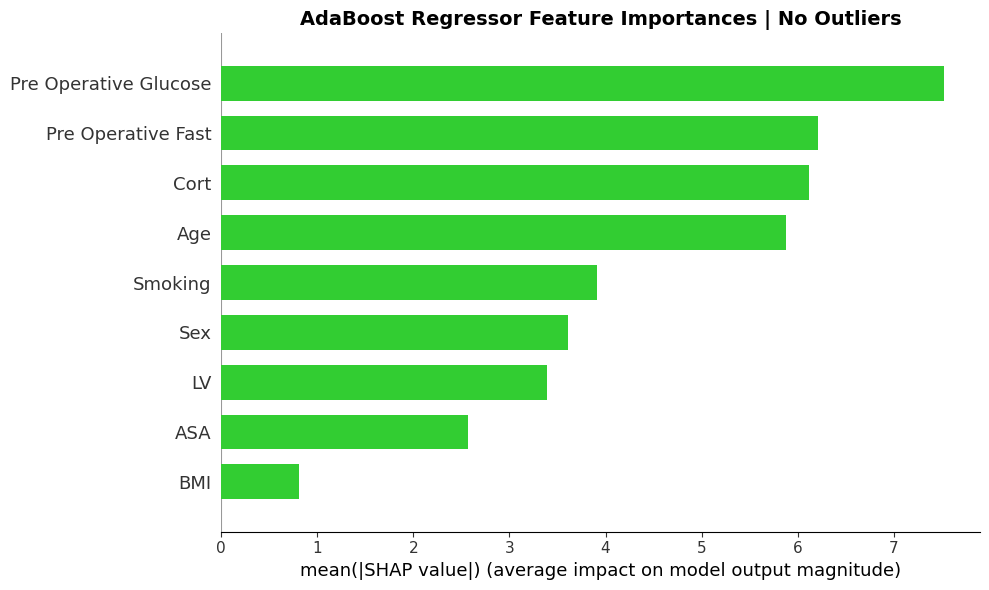

In [37]:
# Plot summary plot to visualize feature importance
plt.title(label = "AdaBoost Regressor Feature Importances | No Outliers" , fontsize = 14, weight = 'bold')

shap.summary_plot(shap_values, X_train, feature_names=X_train.columns, 
                  plot_type='bar', 
                  color=color, plot_size= (10,6))

plt.show()

## 4.7 Residuals' Distribution

In [38]:
# Models' fitted values

fitted_y1 = ABPredictions

# Models' residuals

residuals1 = Y_train - ABPredictions

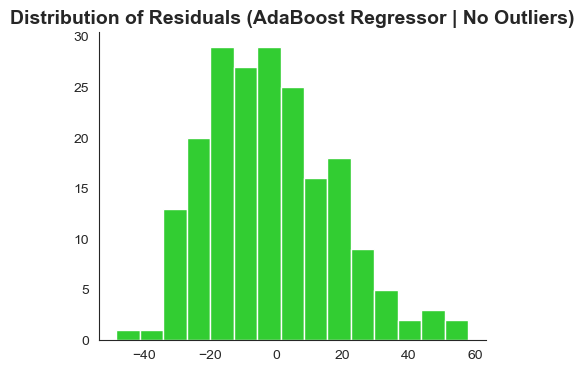

In [39]:
# Histogram of residuals 

sns.set_style("white")
    
plt.figure(figsize=(5,4))
    
plt.hist(residuals1, bins = 15, color = color)
    
plt.title(label = "Distribution of Residuals (AdaBoost Regressor | No Outliers)" , fontsize = 14, weight = 'bold')
    
sns.despine()
    
plt.show()

## 4.8 Scatterplots with fitted line (Train Dataset)

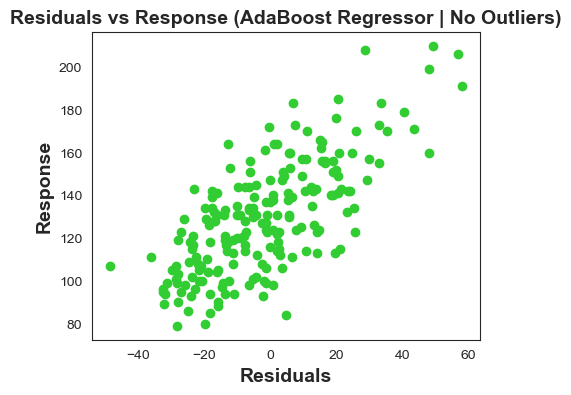

In [40]:
# Plotting residuals vs response 

sns.set_style("white")

plt.figure(figsize=(5,4))

plt.plot(residuals1, Y_train, 'o', color = color)

# Uncomment the following lines to add a fitted line
# b,a = np.polyfit(residuals1, Y_train, 1)

# plt.plot(residuals1, b*residuals1 + a, color = 'black')

plt.title(label = 'Residuals vs Response (AdaBoost Regressor | No Outliers)', fontsize = 14, weight = 'bold')
plt.xlabel('Residuals',fontsize = 14, weight = 'bold')
plt.ylabel('Response',fontsize = 14, weight = 'bold')

plt.show()

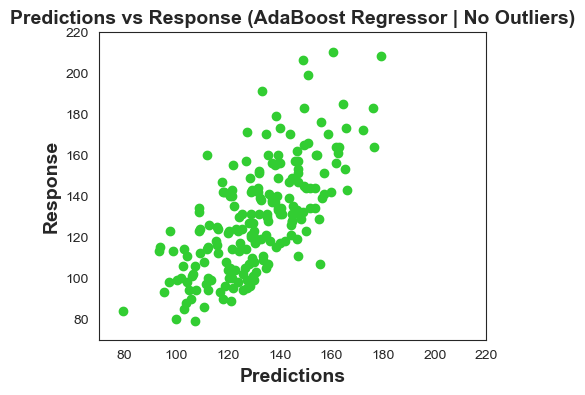

In [41]:
# Plotting predictions vs response 

sns.set_style("white")

plt.figure(figsize=(5,4))

plt.plot(ABPredictions, Y_train, 'o', color = color)

# Uncomment the following lines to add a fitted line
# b,a = np.polyfit(ABPredictions, Y_train, 1)

# plt.plot(ABPredictions, b*ABPredictions + a, color = 'black')

plt.title(label = 'Predictions vs Response (AdaBoost Regressor | No Outliers)', fontsize = 14, weight = 'bold')
plt.xlabel('Predictions',fontsize = 14, weight = 'bold')
plt.ylabel('Response',fontsize = 14, weight = 'bold')

plt.xlim(70, 220)
plt.ylim(70, 220)

plt.show()

## 4.9 Saving Results

In [42]:
# Concatenating the training and test Dataframes

ABResults = pd.concat([Training_metric_df, Test_CV_results, Test_Dat_results], axis =  0)
ABResults

,AdaBoost Regressor
R^2,0.463
Num_of_Feats,9.000
Tr_MAE,15.606
Te_MAE (KFold),15.990
Te_MAE,19.540


In [43]:
# Saving the Results

ABResults.to_csv(r'AdaBoostResultsNoOutliers.csv', index=True, index_label = 'Metric')